# Tutorial - Decomposition of a single spectrum

Here we show how to prepare and decompose a single spectrum. This can be instructive in how parameter settings influence and impact the decomposition and can be helpful in optimizing the settings.

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

from gausspyplus.prepare import GaussPyPrepare
from gausspyplus.decompose import GaussPyDecompose

In the following we manually set the parameters for the GaussPy+ preparation and Stage 1 of the decomposition. 
The values of these parameters correspond mostly to the GaussPy+ default values, which yielded good decomposition results for the fitting of CO spectra. See Table F.2 in [Riener et al. 2019](https://arxiv.org/abs/1906.10506) for a more detailed description of the parameters. 

The most important parameters to change are `alpha1`, `alpha2`, `snr`, and `significance` (also referred to as essential parameters). 

The `alpha1` and `alpha2` parameters define the kernel size for the smoothing. Note how changing their values impacts the second derivative of the smoothed spectrum (shown in red in the upper and lower left panels in the diagnostic plot that is printed after running the cell below). We recommend setting `alpha1` to a lower value than `alpha2`. We only set `alpha1` and `alpha2` manually for this example of a decomposition of a single spectrum. Usually, we would automatically infer the values for `alpha1` and `alpha2` via a training set (see the notebook `Tutorial_example-GRS`).

The `snr` and `significance` parameters define the minimum S/N ratio and the minimum integrated area Gaussian fit components have to fulfill. If you find that ``GaussPy+`` fits too many noise peaks, try setting either the ``significance`` or ``snr`` parameters to higher values. In contrast, if you find that many low-intensity and/or narrow peaks are not fit at all, set one or both of these parameters to lower values. See Sect. 3.2.1.2 and 3.2.1.3 in [Riener et al. 2019](https://arxiv.org/abs/1906.10506) for a description about the ``significance`` and ``snr`` parameters; also see App. C.3 for how changing one or both of these parameters can impact the decomposition results.

The remaining parameters control more advanced settings of the algorithm and we recommend playing around with there values only after good settings for the four essential parameters have been found. However, if you run ``GaussPy+`` on HI datasets we recommend to set the ``decompose.refit_broad`` and ``decompose.refit_blended`` parameters to ``False`` (see Sect. 3.2.2.2 and 3.2.2.3 in [Riener et al. 2019](https://arxiv.org/abs/1906.10506)).


Testing: using only pixel at location (31, 40)

GaussPy decomposition

decomposition settings:
GaussPy:
Two phase decomposition: True
alpha1: 2.58
alpha2: 5.14
SNR1: 3.0
SNR2: 3.0

improve_fitting: True
min_fwhm: 1.0
max_fwhm: None
snr: 3.0
snr_fit: 1.5
significance: 5.0
snr_negative: 3.0
rchi2_limit: None
max_amp_factor: 1.1
neg_res_peak: True
broad: True
blended: True
fwhm_factor: 2.0
separation_factor: 0.8493218
exclude_means_outside_channel_range: True
min_pvalue: 0.01
max_ncomps: None

decomposing data...

  --> AGD() 



  --> initialGuess() 

Algorithm parameters: 
alpha = 2.58
SNR_thesh = 3.0
SNR2_thesh = 3.0
BLFrac = 0.1
Convolution sigma [pixels]: 2.58
...took 0.00 seconds per derivative.
Second derivative noise: 0.0063726414163011455
Second derivative threshold: -0.019117924248903437
Components found for alpha=2.58: 0
Beginning phase-two AGD... 
Phase 2 with no narrow comps -> No intermediate subtration... 


  --> initialGuess() 

Algorithm parameters: 
alpha = 5.14
SNR_th

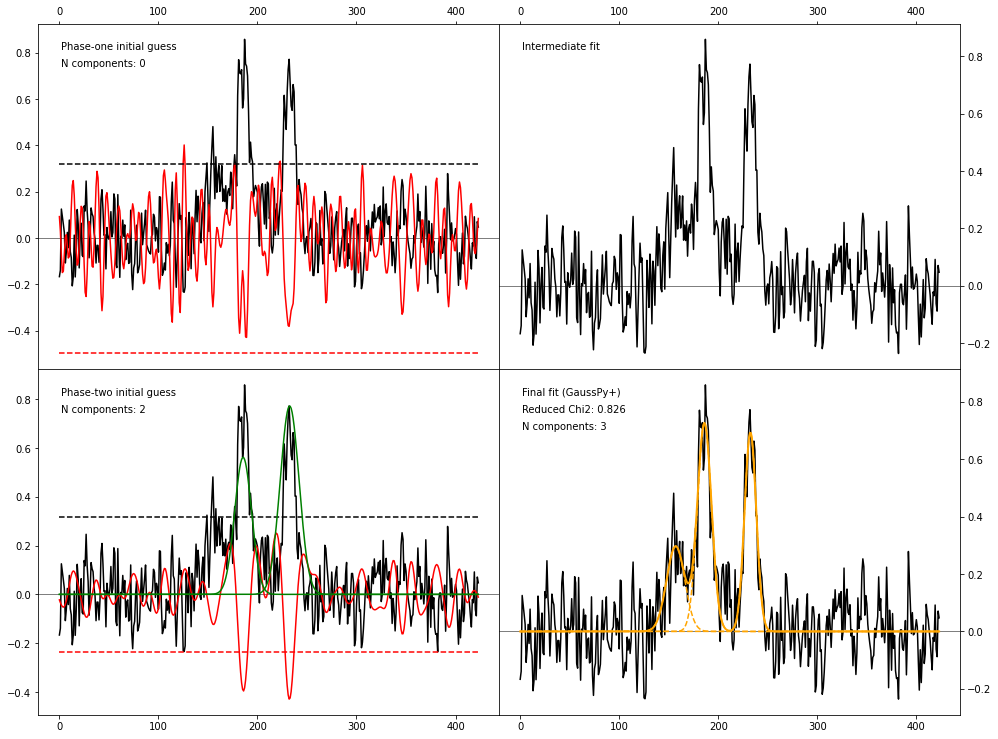

In [9]:
#
#  Set the essential parameters
#  changing these parameters will have the biggest impact on the decomposition results
#

#  First smoothing parameter [float]
alpha1 = 2.58
#  Second smoothing parameter (only used if 'two_phase_decomposition = True') [float]
alpha2 = 5.14
#  Required minimum signal-to-noise ratio for data peak. [float]
snr = 3.
#  Required minimum value for significance criterion. [float]
significance = 5.


#
#  Prepare the spectrum for the decomposition
#

#  Initialize the 'GaussPyPrepare' class
prepare = GaussPyPrepare()
#  Path to the FITS cube.
prepare.path_to_file = os.path.join(
    '..', 'gausspyplus', 'data', 'grs-test_field.fits')
prepare.snr = snr
prepare.significance = significance
#  Probability threshold given in percent for features of consecutive positive 
#  or negative channels to be counted as more likely to be a noise feature [float]
prepare.p_limit = 0.02
#  Number of channels by which an interval (low, upp) gets extended on both sides, 
#  resulting in (low - pad_channels, upp + pad_channels) [int]
prepare.pad_channels = 5
#  Constrict goodness-of-fit calculations to spectral regions estimated 
#  to contain signal [True/False]
prepare.signal_mask = True
#  Required minimum number of spectral channels that the signal ranges should contain [int]
prepare.min_channels = 100
#  Mask out ranges in the spectrum; 
#  specified as a list of tuples [(low1, upp1), ..., (lowN, uppN)]
prepare.mask_out_ranges = []
#  Required signal-to-noise ratio for negative data values 
#  to be counted as noise spikes [float]
prepare.snr_noise_spike = 5.
#  position of the spectrum in the FITS data cube
data_location = (31, 40)  # given in (ypix, xpix)
#  prepare the single spectrum for the decomposition step
prepared_spectrum = prepare.return_single_prepared_spectrum(data_location)


#
#  Decompose the prepared spectrum
#

#  Initialize the 'GaussPyDecompose' class
decompose = GaussPyDecompose()
#  Whether to use one or two smoothing parameters for the decomposition [True/False]
decompose.two_phase_decomposition = True
decompose.alpha1 = 2.58
decompose.alpha2 = 5.14

#  Note the following parameters only take effect if 'improve_fitting' is set to True

#  Use the improved fitting routine [True/False]
decompose.improve_fitting = True
decompose.snr = snr
decompose.significance = significance
#  Exclude Gaussian fit components if their mean position is 
#  outside the channel range. [bool]
decompose.exclude_means_outside_channel_range = True
#  Required minimum value for FWHM values of fitted Gaussian components 
#  specified in fractions of channels. [float]
decompose.min_fwhm = 1.
#  Enforced maximum value for FWHM parameter specified in fractions of channels. 
#  Use with caution! Can lead to artifacts in the fitting. [float]
decompose.max_fwhm = None
#  Required minimum signal-to-noise value for fitted components. 
#  Defaults to 'snr/2' if not specified. [float]
decompose.snr_fit = None
#  Required minimum signal-to-noise value for negative data peaks. 
#  Used in the search for negative residual peaks. 
#  Defaults to 'snr' if not specified. [float]
decompose.snr_negative = None
#  p-value for the null hypothesis that the normalised residual 
#  resembles a normal distribution. [float]
decompose.min_pvalue = 0.01
#  Factor by which the maximum data value is multiplied to get 
#  a maximum limit for the fitted amplitudes.
decompose.max_amp_factor = 1.1
#  Refit negative residual features. [True/False]
decompose.refit_neg_res_peak = True
#  Refit broad components. [True/False]
decompose.refit_broad = True
#  Refit blended components. [True/False]
decompose.refit_blended = True
#  The required minimum separation between two Gaussian components (mean1, fwhm1) 
#  and (mean2, fwhm2) is determined as separation_factor * min(fwhm1, fwhm2). [float]
decompose.separation_factor = 0.8493218
#  factor by which the FWHM value of a fit component has to exceed all other 
#  (neighboring) fit components to get flagged [float]
decompose.fwhm_factor = 2.
#  maximum number of allowed fit components per spectrum. Use with caution. [int]
decompose.max_ncomps = None

decompose.single_prepared_spectrum = prepared_spectrum
decomposed_test = decompose.decompose()
                             

Running the previous cell printed some decomposition diagnostics and produced a multi-panel figure with the following four figures:

- **upper left panel**: This figure shows how GaussPy determines the initial guesses for the Gaussian fit parameters in its first decomposition phase. The original input spectrum is shown in black solid lines and the S/N threshold for the original spectrum (``snr`` parameter) is shown with the horizontal dashed black line. The red line indicates the second derivative of the spectrum that was obtained after smoothing the original spectrum with the $\alpha_{1}$ (``alpha1``) parameter and the red dashed horizontal lines show the corresponding S/N threshold for the second derivative. Initial guesses for the Gaussian fit parameters are shown in green and are determined by peaks in the original spectrum and second derivative of the smoothed spectrum.

- **upper right panel**: This figure shows the intermediate fit results (blue line) obtained with the initial guesses for the Gaussian fit parameters obtained in the first decomposition phase. Note that this step is not performed if the ``two_phase_decomposition`` parameter is set to ``False``.

- **lower left panel**: This figure shows the second decomposition phase of GaussPy, in which it searches for new peaks in the residual from the intermediate fit. This phase proceeds in a similar way to the first phase, with the difference that now the $\alpha_{2}$ (``alpha2``) parameter is used to smooth the residual before the derivatives are computed. Note that this step is not performed if the ``two_phase_decomposition`` parameter is set to ``False``.

- **lower right panel**: This figure shows the final fit results of GaussPy (orange lines). If the ``improve_fitting`` parameter is set to ``True``, the decomposition results correspond to the outcome of the improved fitting routine of GaussPy+, which aims to further improve the final fitting results of GaussPy. Users can set the ``improve_fitting`` parameter to ``True`` or ``False`` to check the effect of the improved fitting routine of GaussPy+. Note that the fit results of GaussPy+ correspond to the stage before the spatially coherent refitting phases, so decomposition results can still change later on based on neighboring fit results.

### Decomposition results

In the preparation and decomposition steps we obtain two dictionaries. Lets first take a look at the contents of the dictionary created in the preparation step:

In [ ]:
prepared_spectrum.keys()

This dictionary contains the following keys:

- **data_list**: A list containing information about the intensity values of the spectra

- **x_values**: A list containing information about the number of spectral channels per spectrum

- **error**: Information about the rms-error of the spectra

- **index**: Index of the spectrum in the dictionary (identical to the **index_fit** keyword in the dictionary containing the decomposition results)

- **location**: Location of the spectrum in the spectral cube; given as (Y position, X position)

- **header**: FITS header of the spectral cube

- **nan_mask**: Information about NaN values contained in the spectral cube

- **signal_ranges**: Regions in the spectrum determined as containing signal peaks. Goodness-of-fit criteria (such as reduced chi-square values and the AICc parameter use only spectral channels contained in these regions)

- **noise_spike_ranges**: Regions in the spectrum determined as containing negative noise spikes. These regions are masked out for goodness-of-fit calculations.

Next, lets take a look of the dictionary containing the decomposition results:

In [ ]:
from pprint import pprint
pprint(decomposed_test)

This dictionary contains the following keys:

- **index_fit**: Index in the dictionary (identical to the 'index' keyword in the dictionary containing the decomposition results)

- **amplitudes_fit**, **fwhms_fit**, **means_fit**: Lists containing the fit parameters of the N Gaussian components of the final fit solution in the form of [amplitude_1, amplitude_2, ..., amplitude_N], [fwhm_value_1, fwhm_value_2, ..., fwhm_value_N], [mean_position_value_1, mean_position_value_2, ..., mean_position_value_N]

- **amplitudes_fit_err**, **fwhms_fit_err**, **means_fit_err**: Lists containing the corresponding errors of the fit parameters

- **best_fit_rchi2**: List of the reduced chi-square values of the best fit solutions

- **best_fit_aicc**: List of the values of the corrected Akaike information criterion for the best fit solutions

- **pvalue**: List of p-values obtained from the normality tests for the normalised residuals

- **amplitudes_initial**, **fwhms_initial**, **means_initial**: Lists containing the fit parameters of the initial guesses for the components (i.e., all components identified in the upper and lower left panels in the Figure above)

- **N_components**: List containing the number of fit components of the best fit solutions

- **N_blended**: List containing the info about the number of blended components

- **N_neg_res_peak**: List containing the info about the number of negative residual peaks introduced by the fit

- **log_gplus**: List containing logs of all successful refits of the spectrum in the improved fitting routine of GaussPy+:
    - 1: new fit component added from search of positive peaks in the residual
    - 2: refit of spectrum due to the presence of negative residual peak(s) in the residual
    - 3: refit of the spectrum due to the presence of broad fit component(s)
    - 4: refit of the spectrum due to the presence of blended fit components

- **quality_control**: List containing logs of fit components by in-built quality criteria:
    - 0: FWHM value of component exceeded the ``max_fwhm`` parameter
    - 1: FWHM value of component was smaller than the ``min_fwhm`` parameter
    - 2: Amplitude value of component did not satisfy the required minimum S/N ratio (default value is ``snr``/2)
    - 3: Significance value of the fit components does not satisfy the required minimum value given by the ``significance``parameter
    - 4: Mean position of the fit component was outside the channel range
    - 5: Mean position of the fit component was outside the determined **signal_ranges** **AND** the fit component did not satisfy the significance criterion)